In [301]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder,PowerTransformer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer,MinMaxScaler
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_log_error,mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import seaborn as sns





In [3]:
%config Completer.use_jedi = False

In [269]:
data = pd.read_csv('train.csv')


In [6]:
data.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [7]:
# take a look at the statisitcs for numerical data like (mean, std, )
data.describe()

,ID,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000
mean,2879.500000,703.483854,11.500000,12.803559,58.361806,1.723333,1473.711458,4.058264,0.572325,0.135122,0.046302
std,1662.913107,655.249491,6.922788,11.902206,19.840167,1.047898,585.879880,13.003582,0.869943,1.075320,0.323728
min,0.000000,0.000000,0.000000,-15.100000,0.000000,0.000000,27.000000,-26.900000,0.000000,0.000000,0.000000
25%,1439.750000,188.000000,5.750000,3.200000,43.000000,0.900000,1025.750000,-5.400000,0.000000,0.000000,0.000000
50%,2879.500000,485.500000,11.500000,13.700000,57.000000,1.500000,1732.000000,5.200000,0.010000,0.000000,0.000000
75%,4319.250000,1066.000000,17.250000,22.225000,73.000000,2.300000,2000.000000,14.700000,0.940000,0.000000,0.000000
max,5759.000000,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,5.100000


In [8]:
#check data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         5760 non-null   int64  
 1   Date                       5760 non-null   object 
 2   y                          5760 non-null   int64  
 3   Hour                       5760 non-null   int64  
 4   Temperature(�C)            5760 non-null   float64
 5   Humidity(%)                5760 non-null   int64  
 6   Wind speed (m/s)           5760 non-null   float64
 7   Visibility (10m)           5760 non-null   int64  
 8   Dew point temperature(�C)  5760 non-null   float64
 9   Solar Radiation (MJ/m2)    5760 non-null   float64
 10  Rainfall(mm)               5760 non-null   float64
 11  Snowfall (cm)              5760 non-null   float64
 12  Seasons                    5760 non-null   object 
 13  Holiday                    5760 non-null   objec

In [11]:
# check nulls in the different features
data.drop(['ID','y'],axis=1).isna().sum()

Date                         0
Hour                         0
Temperature(�C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(�C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

In [61]:
def extract_date_info(data): 
    """
    extract date information from the data column
    args:
    Dataframe to work on
    returns:
    append new column with date data extracted
    """
    data['new_Date']= pd.to_datetime(data['Date'],infer_datetime_format=True,dayfirst=True)
    data['day_of_week'] = data['new_Date'].dt.day_name()
    
    

    #encode the weekend..weekday have average rental more than the weekend
    weekends = {'Monday':0,'Tuesday':0,'Wednesday':0,'Thursday':0,'Friday':0,'Saturday':1,'Sunday':1}
    data['is_weekend'] = data['day_of_week'].apply(lambda x: weekends[x])
    
    # encode the day of the week based on rental average, the more the the higher the value
    days = {'Monday':4,'Tuesday':3,'Wednesday':5,'Thursday':0,'Friday':6,'Saturday':2,'Sunday':1}
    data['day_of_week'] = data['day_of_week'].apply(lambda x: days[x])
    
    #encode the holiday column 
    holiday = {"Holiday":1,"No Holiday":0}
    data["is_holiday"] = data.apply(lambda x : holiday[x["Holiday"]]  ,axis=1)
    
    #add new column to show is day or night 
    data['label_day_night'] = 1
    data.loc[(data['Hour'] < 6) | (data['Hour'] > 20), 'label_day_night'] = 0
    
    #extract date info month, day, year 
    data["day"] = data["Date"].apply(lambda x: x[0:2])
    data["month"] = data["Date"].apply(lambda x: x[3:5])
    data["year"] = data["Date"].apply(lambda x: x[6:10])



In [270]:
#extract the date data like year, month, day, day of week
extract_date_info(data)

<AxesSubplot:>

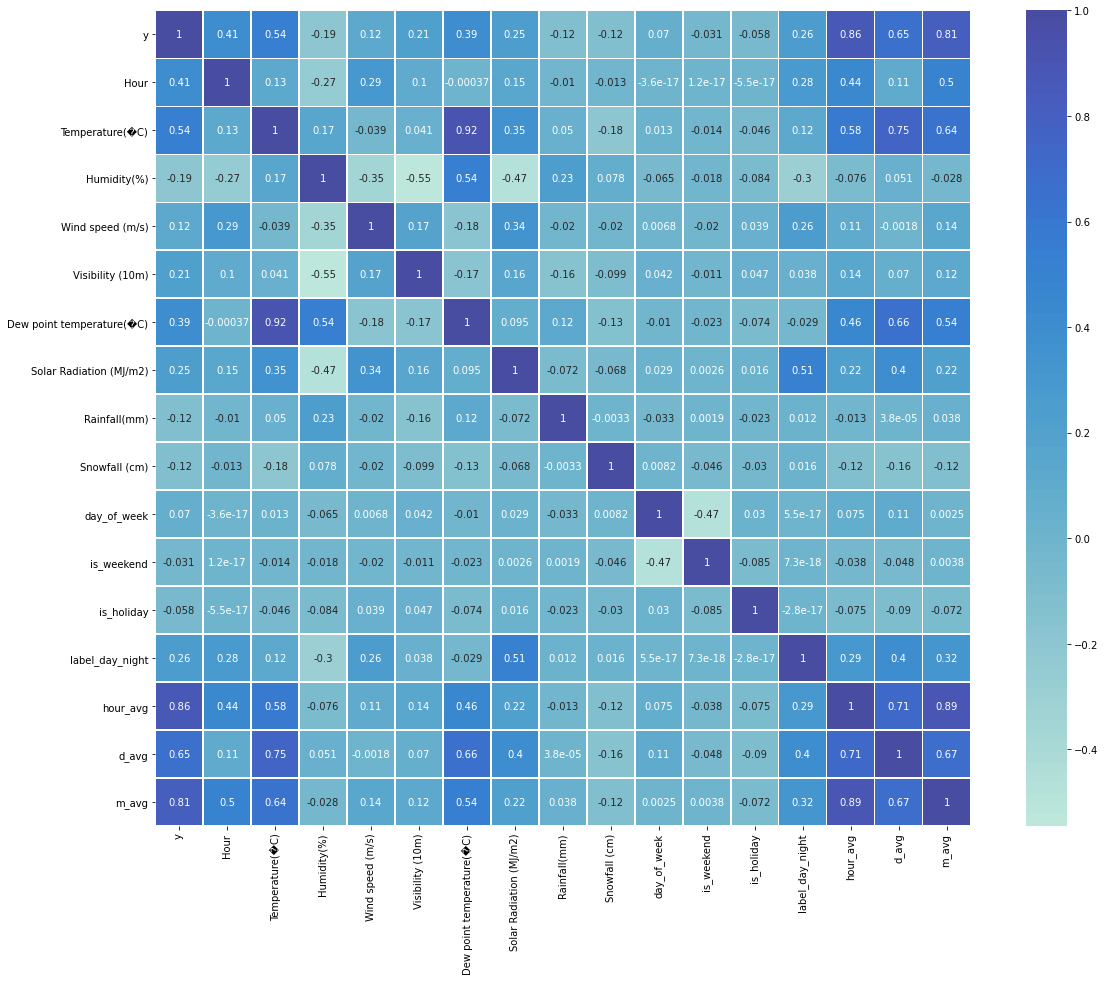

In [18]:
#display heatmap for correlation
corr = data.drop(["ID"], axis=1).corr()
fig , ax =  plt.subplots(1,1,figsize = (20,15))
sns.heatmap(corr,square=True, annot = True, linewidth = .5, center = 2, ax = ax,cbar=True)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


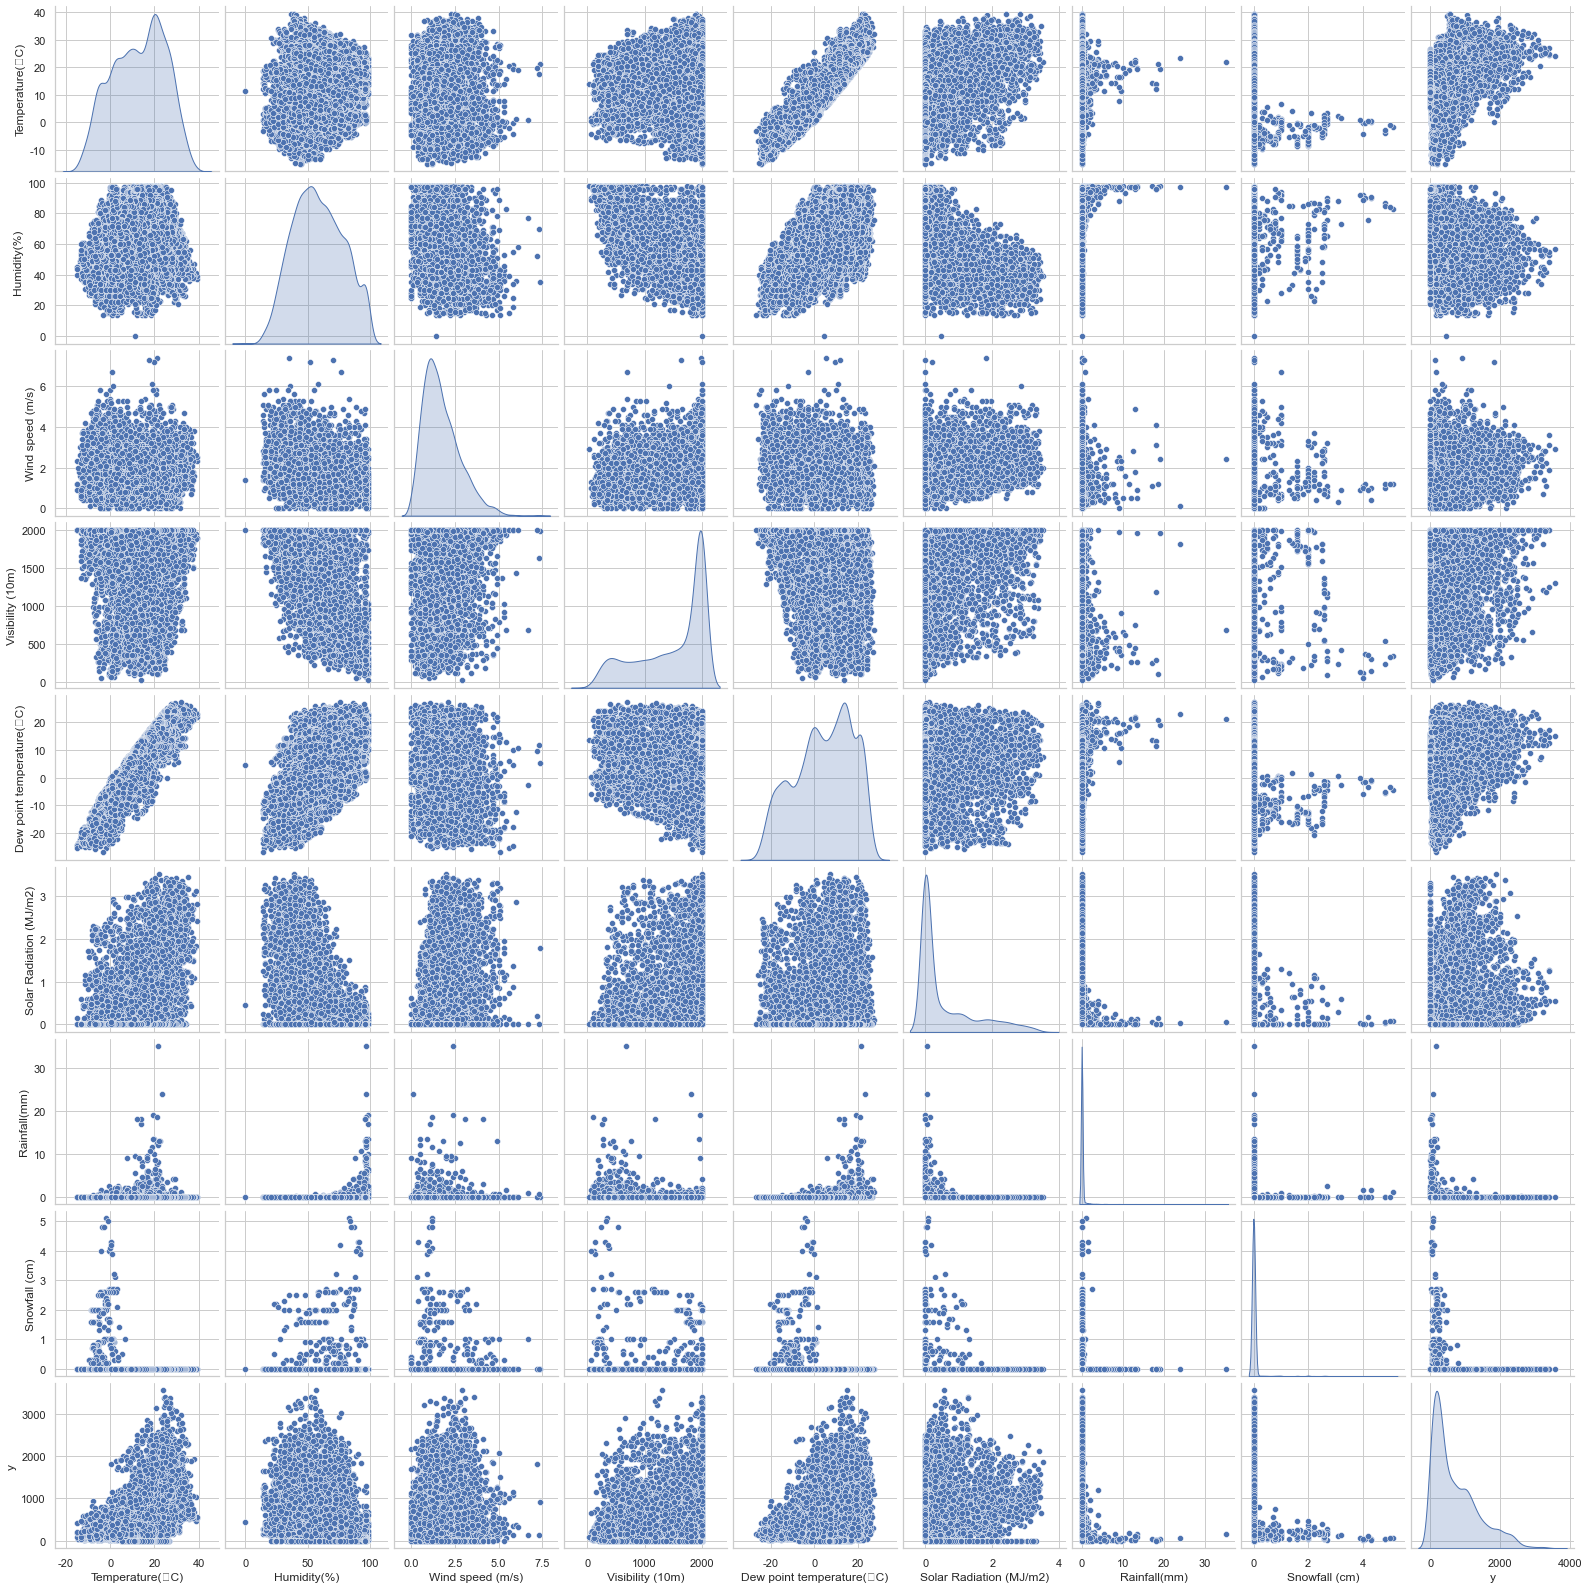

In [26]:
# use pair plot to show relation between the data 
numerical_features = data[['Temperature(�C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',"y"]]
plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']
sns.set_theme(style="whitegrid")
sns.pairplot(numerical_features,diag_kind='kde')

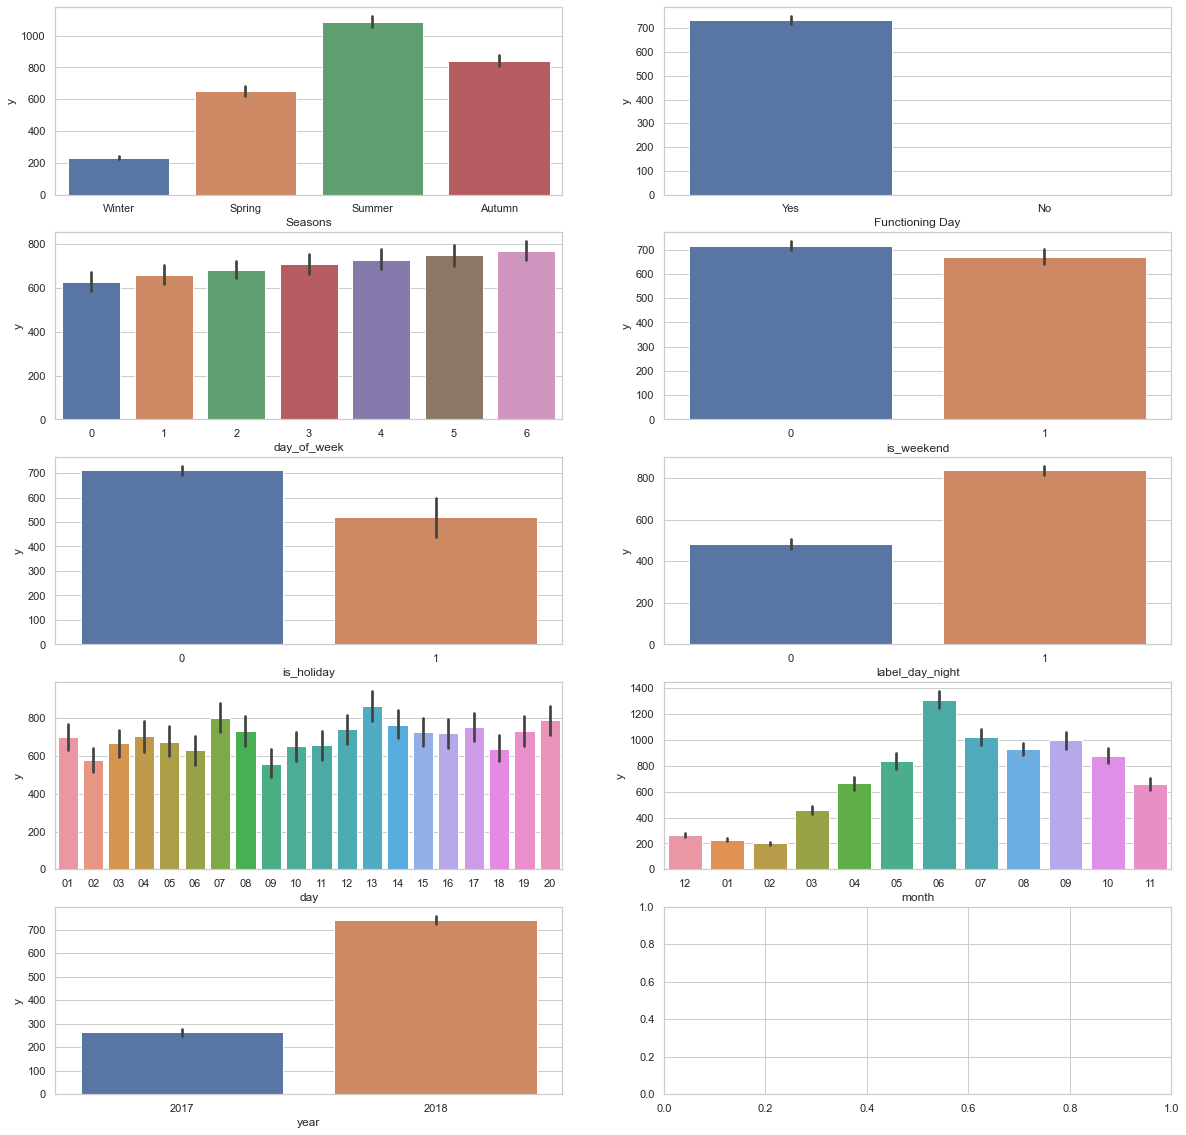

In [36]:
categoical_cols = ['Seasons', 'Functioning Day', 'day_of_week', 'is_weekend',
       'is_holiday', 'label_day_night', 'day', 'month', 'year']


grid_row = int(len(categoical_cols)/2) + len(categoical_cols)%2
grid_col = 2

fig , axes =  plt.subplots(grid_row,grid_col,figsize=(20,20))
for i in range(len(categoical_cols)):
        sns.barplot(x=categoical_cols[i],y='y',ax=axes[int(i/2)][int(i%2)],data=data)
plt.show()

In [226]:
# grid_row = int(len(numerical_features)/2) + len(numerical_features)%2
# grid_col = 2

# fig , axes =  plt.subplots(grid_row,grid_col,figsize=(20,20))
# for i in range(len(numerical_features)):
#         sns.histplot(x=numerical_features[i],ax=axes[int(i/2)][int(i%2)],data=data)
# plt.show()

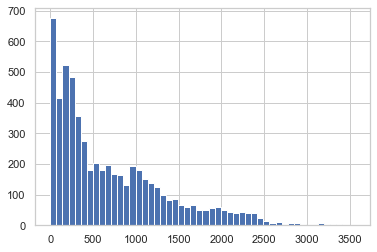

In [215]:
# plot the target histogram distribution
plt.hist(data["y"],bins=50)
plt.show()

<AxesSubplot:xlabel='Visibility (10m)'>

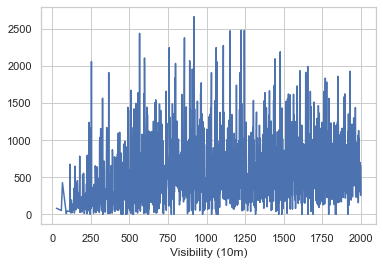

In [44]:
# show y distribution with visibilty  
data.groupby(["Visibility (10m)"])["y"].median().plot()


In [271]:
new_data = pd.DataFrame(pd.date_range(start='12/01/2017', end='11/21/2018', freq='H'),columns=["date_hour"])
new_data["Hour"] = new_data["date_hour"].apply(lambda x : x.hour ) 
new_data["new_Date"] = new_data["date_hour"].apply(lambda x : x.date())
new_data["new_Date"] = pd.to_datetime(new_data["new_Date"])
data = data.merge(new_data, on=['new_Date',"Hour"],how='left')

In [272]:
# calculate exponential weighted moving average of day of the week during every hour
day_ofweek_avg = data.sort_values(['date_hour']).groupby(["year","month","day_of_week","Hour"])['y'].apply(lambda x: x.ewm(span=3).mean().iloc[-1]).to_dict()
data['day_of_week_avg'] =  data.sort_values(['date_hour']).groupby(["year","month","day_of_week",'Hour'])['y'].transform(lambda x: x.ewm(span=2).mean())

In [273]:
# calculate exponential weighted moving average of day of the month during every hour
month_avg = data.sort_values(['date_hour']).groupby(["year","month","Hour"])['y'].apply(lambda x: x.ewm(span=2).mean().iloc[-1]).to_dict()
data['month_avg'] =  data.sort_values(['date_hour']).groupby(["year","month","Hour"])['y'].transform(lambda x: x.ewm(span=3).mean())

In [279]:
#pipline to scale and encode the features
log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False),
#     StandardScaler()
)

linear_model_preprocessor = ColumnTransformer(
    [
         ("binned_numeric3", StandardScaler(),
            ["Humidity(%)"]),
        ("binned_numeric4", StandardScaler(),
            ["Wind speed (m/s)"]),
         ("binned_numeric5",MinMaxScaler() ,
            ["Visibility (10m)"]),
        ("binned_numeric2", StandardScaler(),
            ["Temperature(�C)"]),
      
        ("log_scaled_numeric", StandardScaler(),
            ["month_avg"]),
          ("log_scaled_numeric1", StandardScaler(),
            ["day_of_week_avg"]),
        ("binned_numeric1", make_pipeline(MinMaxScaler(),PolynomialFeatures(degree=3)),
            ["Rainfall(mm)"]),
        ("binned_numeric", make_pipeline(MinMaxScaler(),PolynomialFeatures(degree=3)),
            ["Snowfall (cm)"]),
        ("binned_numeric9", StandardScaler(),
            ["Solar Radiation (MJ/m2)"]),
#         ("log_scaled_numeric2", MinMaxScaler(),
#             ["Dew point temperature(�C)"]),

        ("log_scaled_numeric3", MinMaxScaler(),
            ["is_holiday"]),
        ("onehot_categorical", OneHotEncoder(),
            ["Seasons","year","day_of_week","Hour","label_day_night","Functioning Day","is_weekend"])
    ],
    
    remainder="drop",
)


In [280]:
# preform the transformation on data
transdata = linear_model_preprocessor.fit_transform(data)

In [281]:
# split the data
x_train,x_valid,y_train,y_valid = train_test_split(transdata,data['y'], test_size=0.3, random_state=0)


In [282]:
#train the model
random_forest = RandomForestRegressor(
     random_state=10)

random_forest.fit(x_train, np.log(y_train+1))

RandomForestRegressor(random_state=10)

In [283]:
print("random forest Root mean squared log error accuracy",np.sqrt(mean_squared_log_error(y_valid,np.exp(random_forest.predict(x_valid)))))

random forest Root mean squared log error accuracy 0.23372829958106348


In [284]:
df_train, df_test = train_test_split(data, test_size=0.1, random_state=0)

xgboost = XGBRegressor(
    objective="reg:squarederror",
    n_jobs=-1,
    learning_rate=0.1,
    random_state=0,
    colsample_bytree= 0.5,
    n_estimators= 200,
    reg_lambda= 0
    
)
xgboost.fit(x_train, np.log(y_train+1) )
print("XgBoost Root mean squared log error accuracy",np.sqrt(mean_squared_log_error(y_valid,np.exp(xgboost.predict(x_valid)))))


XgBoost Root mean squared log error accuracy 0.23225665323594055
